In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure as fig
import seaborn as sns
import sklearn
from sklearn import model_selection
from sklearn import preprocessing
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

In [4]:
#Data
df = pd.read_csv("dataset/dengue_features_train.csv")
dum = pd.get_dummies(df['city'])
df = pd.concat([dum,df],axis=1)
df = df.drop(columns = ['city'])
df = df.drop(columns = ['week_start_date'])
ef = pd.read_csv("dataset/dengue_labels_train.csv")
ef = ef.drop(columns = ['year','weekofyear','city'])

#Data for inference
ind = pd.read_csv("dataset/dengue_features_test.csv")
dum = pd.get_dummies(ind['city'])
ind = pd.concat([dum,ind],axis=1)
ind = ind.drop(columns = ['city'])
ind = ind.drop(columns = ['week_start_date'])


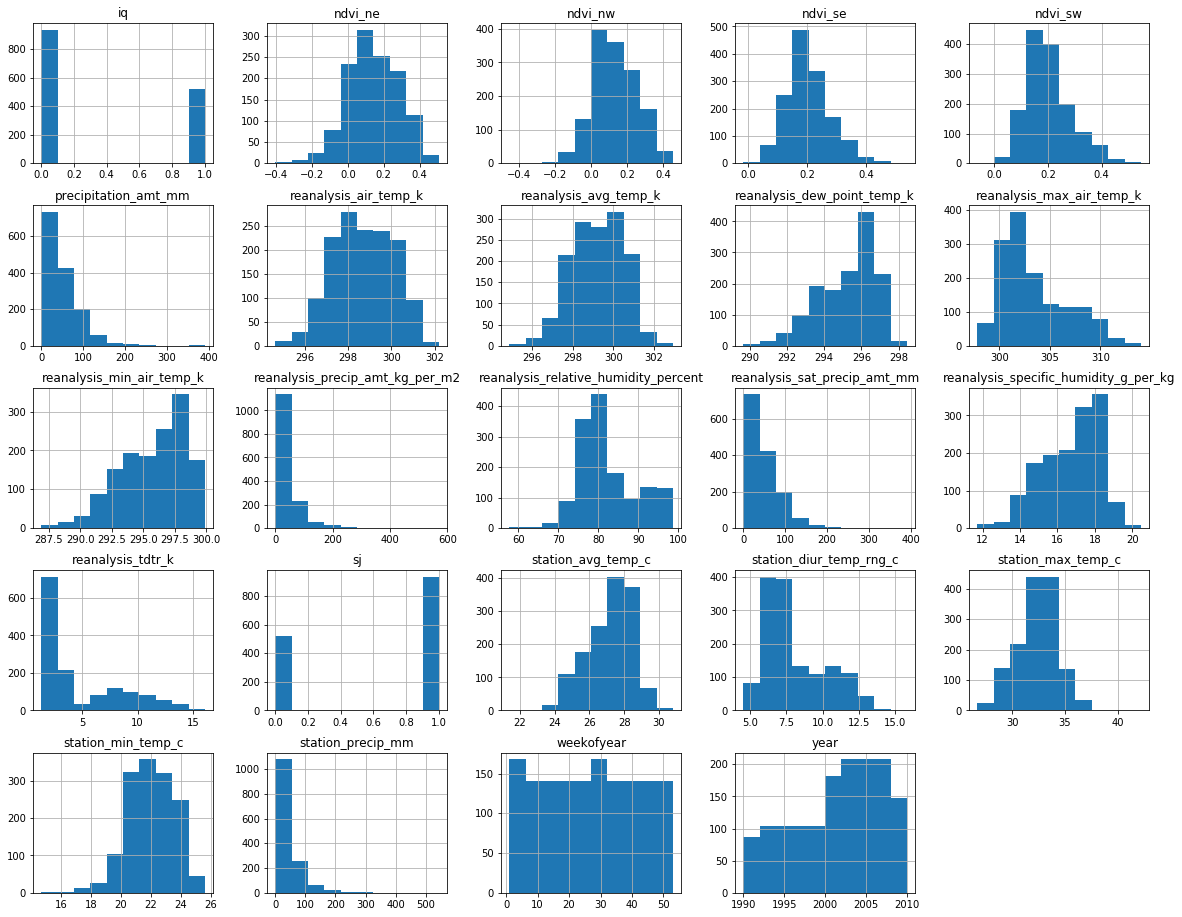

In [5]:
#histogram for all features
df.hist(figsize=(20,16))
plt.show()

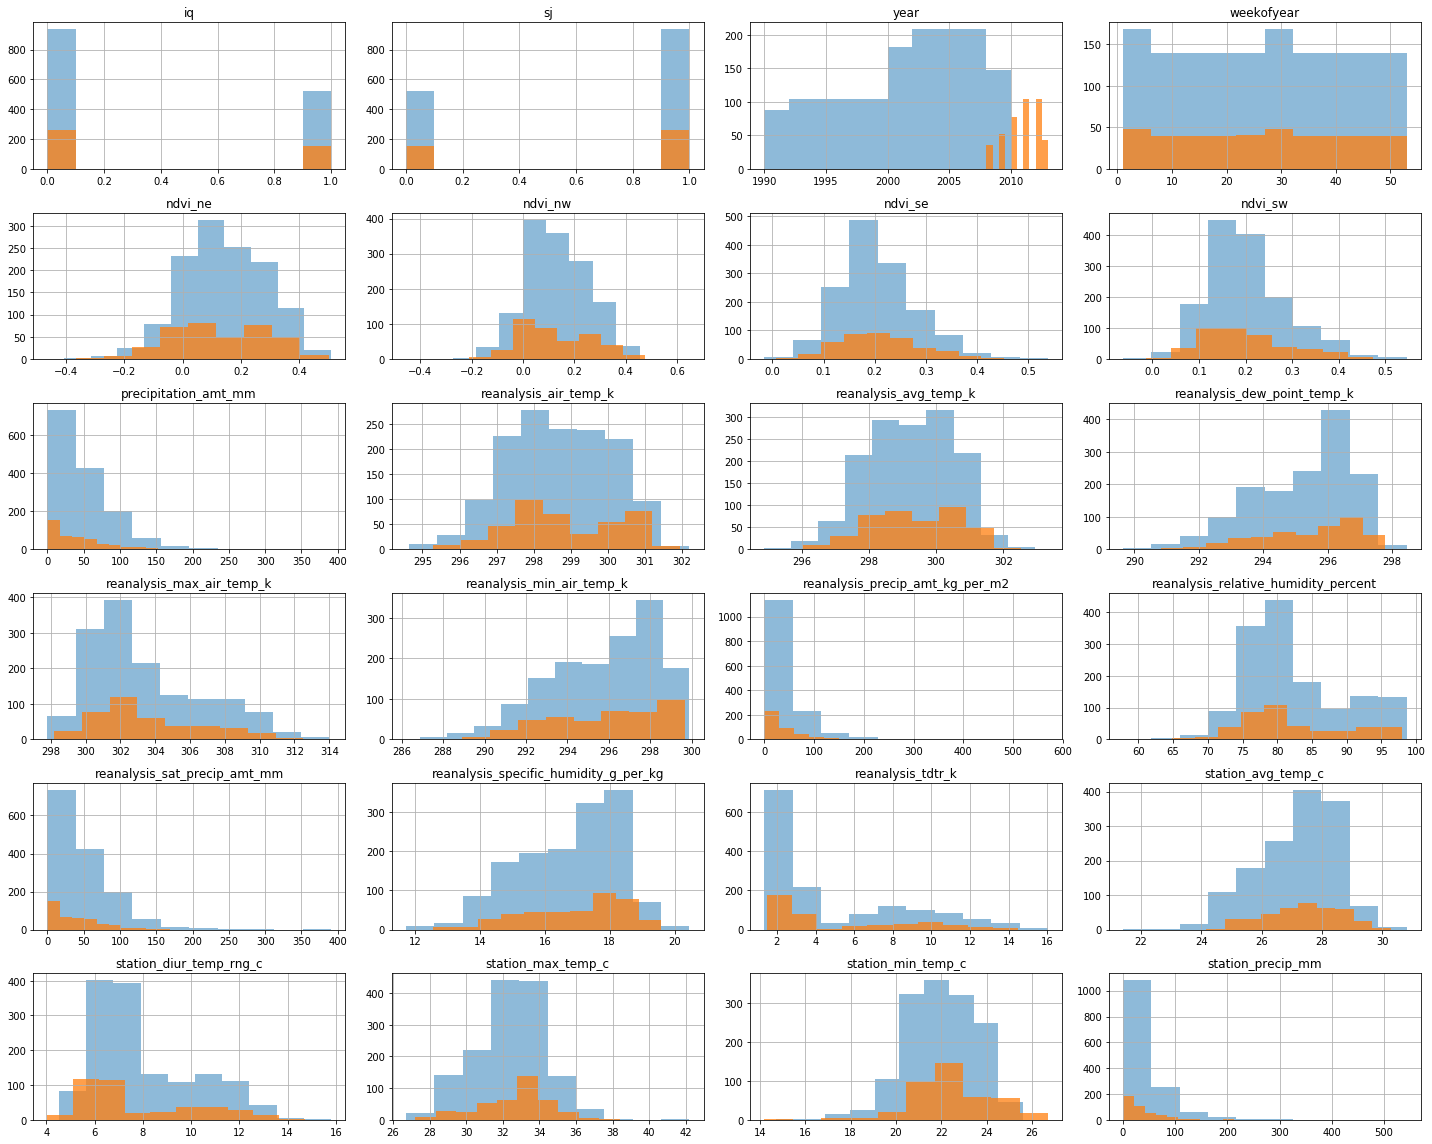

In [6]:
for c1,i in zip(df.columns,range(1,25)):
    plt.tight_layout()
    plt.subplot(6, 4, i) 
    df[c1].hist(figsize=(20,16),alpha=0.5, label=c1)
    ind[c1].hist(figsize=(20,16),alpha=0.75, label=c1)
    plt.title(c1)

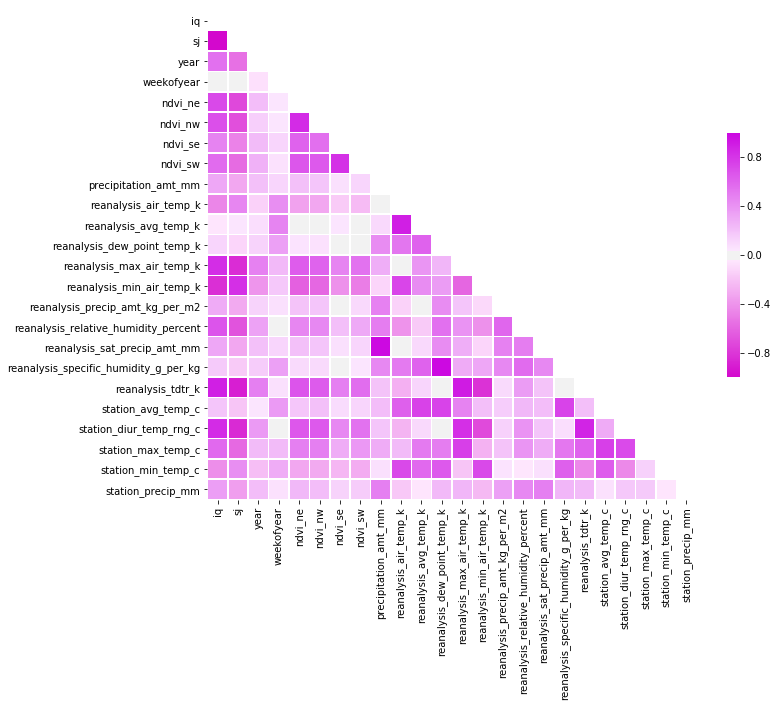

In [8]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(310, 300,s=99, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap,vmax = 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
df.fillna(method='ffill', inplace=True)

def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + [' + '.join(x) for x in combos]
    
    # Find interactions
    poly = PolynomialFeatures(degree = 2,interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    return df
df = add_interactions(df)
print(df.head(5))

    iq   sj    year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se   ndvi_sw  \
0  0.0  1.0  1990.0        18.0  0.122600  0.103725  0.198483  0.177617   
1  0.0  1.0  1990.0        19.0  0.169900  0.142175  0.162357  0.155486   
2  0.0  1.0  1990.0        20.0  0.032250  0.172967  0.157200  0.170843   
3  0.0  1.0  1990.0        21.0  0.128633  0.245067  0.227557  0.235886   
4  0.0  1.0  1990.0        22.0  0.196200  0.262200  0.251200  0.247340   

   precipitation_amt_mm  reanalysis_air_temp_k  \
0                 12.42             297.572857   
1                 22.82             298.211429   
2                 34.54             298.781429   
3                 15.36             298.987143   
4                  7.52             299.518571   

                    ...                    \
0                   ...                     
1                   ...                     
2                   ...                     
3                   ...                     
4                   ...

In [12]:
from sklearn.cross_validation import train_test_split
import sklearn.feature_selection
from sklearn.preprocessing import MinMaxScaler
try:
    df = df.drop(columns = ['iq + sj'])
except:
    pass
#medd = df.median()
#std = df.std()
maxx = df.max()
maxx['year'] = 2013
print(maxx)
minn = df.min()
df = (df-minn)/(maxx - minn)
print(df.head())
X_train, X_test, y_train, y_test = train_test_split(df, ef, train_size=1, random_state=1)
select = sklearn.feature_selection.SelectKBest(k=50)
selected_features = select.fit(X_train, y_train)
indices_selected = selected_features.get_support(indices=True)
colnames_selected = [df.columns[i] for i in indices_selected]

X_train_selected = X_train[colnames_selected]
X_test_selected = X_test[colnames_selected]


/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:109: RuntimeWarning: invalid value encounter

iq                                                                          1.000000
sj                                                                          1.000000
year                                                                     2013.000000
weekofyear                                                                 53.000000
ndvi_ne                                                                     0.508357
ndvi_nw                                                                     0.454429
ndvi_se                                                                     0.538314
ndvi_sw                                                                     0.546017
precipitation_amt_mm                                                      390.600000
reanalysis_air_temp_k                                                     302.200000
reanalysis_avg_temp_k                                                     302.928571
reanalysis_dew_point_temp_k                                      

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import  ExtraTreesRegressor
from sklearn.ensemble import  BaggingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import BaggingClassifier

def find_model_perf(X_train, y_train, X_test, y_test,model):
    model.fit(X_train, y_train)
    y_hat = [int(max(x,0)) for x in model.predict(X_test)]
    print(model,"\n","testing error", mean_absolute_error(y_test,y_hat))
    print("\n")
    return  np.array(y_hat)

In [14]:
model = [HuberRegressor(),
         GradientBoostingRegressor(learning_rate=0.05,n_estimators =220 ,random_state=10,max_features=42,max_depth = 5, min_samples_split = 2), 
         ExtraTreesRegressor(n_estimators=131,max_depth=15,min_samples_split = 2)]
for mod in model:
    find_model_perf(X_train_selected, y_train, X_test_selected, y_test,mod)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False) 
 testing error 19.89828178694158


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=42,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=220, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False) 
 testing error 19.90721649484536


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=131, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


In [15]:
# ''''from sklearn.model_selection import GridSearchCV
# param_test1 = {'n_estimators':range(130,300,10)}
# gsearch1 = GridSearchCV(estimator = ExtraTreesRegressor(max_depth=15,min_samples_split = 2), 
# param_grid = param_test1, scoring='mean_absolute_error',n_jobs=4,iid=False, cv=5)
# gsearch1.fit(X_train_selected,y_train)
# gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_''''

SyntaxError: EOL while scanning string literal (<ipython-input-15-fececd6d9118>, line 6)

In [16]:
FinalModel = GradientBoostingRegressor(learning_rate=0.05,n_estimators =220 ,random_state=10,max_features=42,max_depth = 5, min_samples_split = 2)
FinalModel.fit(X_train_selected,y_train)
FinalModel.fit(X_test_selected,y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=42,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=220, presort='auto', random_state=10,
             subsample=1.0, verbose=0, warm_start=False)

In [17]:
FinalModel2 = ExtraTreesRegressor(n_estimators=131,max_depth=15,min_samples_split = 2)
FinalModel2.fit(X_train_selected,y_train)
FinalModel2.fit(X_test_selected,y_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=15,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=131, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
ind = ind.interpolate()
ind = add_interactions(ind)
ind = ind.drop(columns = ['iq + sj'])
#minn = ind.min()
#maxx = ind.max()
maxx['year'] = 2013
ind = (ind-minn)/(maxx-minn)

In [19]:
X_inf_selected = ind[colnames_selected]


In [20]:
y_inf2 = np.array([int(max(x,0)) for x in FinalModel.predict(X_inf_selected)])
y_inf1 = np.array([int(max(x,0)) for x in FinalModel2.predict(X_inf_selected)])
print(y_inf2)
print(y_inf1)
y_inf2 = (y_inf1 + y_inf2)/2
print(y_inf2)

[ 23  10   0 105  15  37  26  38  28  36  33 121  10  29  72  28  33  50
 101  51  58  27  64  25  27  12  20  26  26  23  21  10  25  22  17  13
  14  29  10  61  14  23  16  15   9  18  14  10  14  11  14  10  16   7
  19  23   7  10  29  76  54 103  50  60  66  88 100  46  84  80  78  69
  39  51 129 161  77  23  54  37  34  25  30  15  21  40  14  25  21  17
  27  16  27  17  16  18  27  33  13  11  27  17  13  18  28  32  22  18
  24 107  51  55  28  26  50  71  34  17  41  74  66  53 146  46 106  53
  32  48  76  46  32  31  33  10  22  16  17  23   5  19  47  30  28  20
  13  14  13  16  20  12  21  15  15  18  11  16  13  30  27  25  35  21
  71 103  84  84  34  90  49  28  34  95  24 125  55  47  83  33  51  81
  29  28  16  22  18  19  50  35  14  40  19  22  33  19  18  30  18  14
  19  17   8  12  12   7  11  20   7  24   6  61  22  49   8  11  29  32
 165  91  23  20  44  56  30  55  33  70  31  99 120  87 109  27  15  15
  24  31  40  84  18  16  36  23  12  19  50  16  1

In [21]:
gf = pd.read_csv("dataset/submission_format.csv")
mat = np.array(y_inf2,dtype=np.int8)
gf['total_cases'] = pd.DataFrame(mat)
print(gf.head())
gf.to_csv("submissions/Extra_tree_1.csv",index=False)

  city  year  weekofyear  total_cases
0   sj  2008          18           19
1   sj  2008          19           12
2   sj  2008          20            9
3   sj  2008          21           76
4   sj  2008          22           19
